In [1]:
# Imports for this project
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils import data
from tqdm import tqdm

In [2]:
# Grab the MNIST dataset
training_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
testing_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [2]:
# Verify that GPU is connected and available

print(torch.__version__)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'The system GPU | {torch.cuda.get_device_name(0) if not None else 'Error'} | is {'AVAILABLE' if torch.cuda.is_available() else 'NOT AVAILABLE' }')

2.6.0+cu124
The system GPU | NVIDIA GeForce RTX 4080 | is AVAILABLE


In [4]:
class MNIST_Auto_Encoder(nn.Module):
    def __init__(self, bottleneck, hidden_layer_size=784):
        super().__init__()
        
        # Defined number of features for the image
        input_size=784

        # Encoder section
        self.encoder = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=hidden_layer_size), # Input to hidden
            nn.ReLU(inplace=True),                                             # Activation Function
            nn.Linear(in_features=hidden_layer_size, out_features=bottleneck)  # Hidden to bottleneck
        )

        # Decoder Section
        self.decoder = nn.Sequential(
            nn.Linear(in_features=bottleneck, out_features=hidden_layer_size), # Bottleneck to hidden
            nn.ReLU(inplace=True),                                             # Activation Function
            nn.Linear(in_features=hidden_layer_size, out_features=input_size), # Hidden to output
            nn.Sigmoid(inplace=True)                                           # Force output pixels to be between 0 and 1
        )

    def forward(self, x) -> torch.Tensor:
        
        # Extract batch size and resize input into the nn
        batch_size = x.size(0)
        x_flattened = x.view(batch_size, -1)

        # Encode then decode the input
        x_encoded = self.encoder(x_flattened)
        x_decoded = self.decoder(x_encoded)

        # Reshape decoded x for final result
        x_predicted = x_decoded.view(batch_size, 1, 28, 28)
        
        return x_predicted
        

In [5]:
# Store the data for this test
k_over_training_loss = []
k_over_testing_loss = [] 


epoch_over_training_loss = []
epoch_over_testing_loss = []

'''
Data for the graph will be in the form of
{
    k: int
    final_training/testing_loss: float
}
'''

def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

In [ ]:
# Model hyperparameters
epochs = 10
batch_size = 64
learning_rate = 0.1

# Question specific hyperparameters
hidden_layer_size = 1000
k_start = 748
k_end = 0
k_step = 160

# Loop through each bottlenecks
for k in range(k_start, k_end, k_step):
    
    print(f'########## With bottleneck = {k} ############')
    
    train_loader = data.DataLoader(training_set, 
                                    batch_size=batch_size, 
                                    shuffle=True,
                                    num_workers=5, 
                                    pin_memory=True
                               )
    
    test_loader = data.DataLoader(testing_set, 
                                    batch_size=batch_size, 
                                    shuffle=False,
                                    num_workers=5, 
                                    pin_memory=True
                               )

    model = MNIST_Auto_Encoder(k, hidden_layer_size=hidden_layer_size)
    model.to(device)

    total_params, trainable_params = count_parameters(model)

    print(f' ~~ Total/Trainable Parameters: {total_params}')

    loss_function = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Have references to variables outside of the epoch loop
    avg_training_loss = 0
    avg_testing_loss = 0

    print(model)

    # Epoch Loop
    for epoch in range(epochs):
        print(f'----- Epoch: {epoch + 1}/{epochs} -----')

        # Per epoch reset accumulated loss
        avg_training_loss = 0
        avg_testing_loss = 0

        # Run through each batch
        for images, _ in tqdm(train_loader, desc='Training', unit=' batch'):
            # Move data into the GPU
            images = images.to(device)

            # Zero out gradients
            optimizer.zero_grad()

            # Calc loss
            generated_images = model(images)
            loss = loss_function(generated_images, images)

            # Calc gradient and step
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                avg_training_loss += loss.item()

        # Set up for calculating testing loss
        avg_training_loss /=  len(train_loader)

        model.eval()

        # Calc training loss
        with torch.no_grad():
            for test_images, _ in tqdm(test_loader, desc='Testing', unit=' batch'):
                test_images = test_images.to(device)
                generated_test_images = model(test_images)
                
                avg_testing_loss += loss_function(generated_test_images, test_images).item()

        avg_testing_loss /=  len(test_loader)

        model.train()
        
        print("")

        print(f'   -> Training Loss: {avg_training_loss: .4f}\n')
        print(f'   -> Testing Loss: {avg_testing_loss: .4f}\n')

    # Add end results to the lists
    k_over_training_loss.append({
        "k": k,
        "training_loss": avg_training_loss 
    })

    k_over_testing_loss.append({
        "k": k,
        "testing_loss": avg_testing_loss
    })



        


In [ ]:
ks = [d["k"] for d in k_over_training_loss]
train_loss = [d["training_loss"] for d in k_over_training_loss]
test_loss = [d["testing_loss"] for d in k_over_testing_loss]

plt.figure(figsize=(8, 5))
plt.plot(ks, train_loss, label="Training Loss")
plt.plot(ks, test_loss, label="Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MNIST AutoEncoder: Bottleneck vs. Training/Testing Loss")
plt.legend()
plt.grid(True)
plt.show()

In [5]:
def freeze_module(m):
    for p in m.parameters():
        p.requires_grad = False

def unfreeze_module(m):
    for p in m.parameters():
        p.requires_grad = True

epoch_over_training_loss_per_model = []
epoch_over_testing_loss_per_model = []

'''
For of the data will be....

data = {
    epoch: int
    training/testing loss: float
    model_name: str
}
'''

'\nFor of the data will be....\n\ndata = {\n    epoch: int\n    training/testing loss: float\n    model_name: str\n}\n'

In [ ]:
optimal_k = 10 # PLACEHOLDER

# Have reference
src_model = model

# 1. Untrained encoder not frozen
encoder_clean_unfrozen = MNIST_Auto_Encoder(optimal_k, hidden_layer_size=hidden_layer_size).to(device).encoder

# 2. Untrained encoder but frozen
encoder_clean_frozen = MNIST_Auto_Encoder(optimal_k, hidden_layer_size=hidden_layer_size).to(device).encoder
freeze_module(encoder_clean_frozen)
unfreeze_module(encoder_clean_frozen[-1])

# 3. Trained encoder not frozen
encoder_trained_unfrozen = MNIST_Auto_Encoder(optimal_k, hidden_layer_size=hidden_layer_size).to(device).encoder
encoder_trained_unfrozen.load_state_dict(src_model.encoder.state_dict())

# 4. Trained encoder but frozen
encoder_trained_frozen = MNIST_Auto_Encoder(optimal_k, hidden_layer_size=hidden_layer_size).to(device).encoder
encoder_trained_frozen.load_state_dict(src_model.encoder.state_dict())

freeze_module(encoder_trained_frozen)
unfreeze_module(encoder_trained_frozen[-1])

models = [encoder_clean_unfrozen, encoder_clean_unfrozen, encoder_trained_unfrozen, encoder_trained_frozen]



NameError: name 'model' is not defined

In [ ]:
# Model hyperparameters
epochs = 10
batch_size = 64
learning_rate = 0.1

print(f'######## Begin Training Encoders on bottleneck={optimal_k} ########')


train_loader = data.DataLoader(training_set, 
                                batch_size=batch_size, 
                                shuffle=True,
                                num_workers=5, 
                                pin_memory=True
                            )

test_loader = data.DataLoader(testing_set, 
                                batch_size=batch_size, 
                                shuffle=False,
                                num_workers=5, 
                                pin_memory=True
                            )

for sample_model, model_name in zip(models, ['Unfrozen Clean Encoder', 'Frozen Clean Encoder', 'Unfrozen Pretrained Encoder', 'Frozen Pretrained Encoder']):

    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.SGD(sample_model.parameters(), lr=learning_rate)

    avg_training_loss = 0
    avg_testing_loss = 0

    for epoch in range(epochs):
        print(f'----- Epoch: {epoch + 1}/{epochs} -----')

        # Per epoch reset accumulated loss
        avg_training_loss = 0
        avg_testing_loss = 0

        # Run through each batch
        for images, labels in tqdm(train_loader, desc='Training', unit=' batch'):
            # Move data into the GPU
            images = images.to(device)

            # Zero out gradients
            optimizer.zero_grad()

            # Calc loss
            logits = sample_model(images)
            loss = loss_function(logits, labels)

            # Calc gradient and step
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                avg_training_loss += loss.item()

        # Set up for calculating testing loss
        avg_training_loss /=  len(train_loader)

        sample_model.eval()

        # Calc training loss
        with torch.no_grad():
            for test_images, labels in tqdm(test_loader, desc='Testing', unit=' batch'):
                test_images = test_images.to(device)
                logits = sample_model(test_images)
                
                avg_testing_loss += loss_function(logits, labels).item()

        avg_testing_loss /=  len(test_loader)

        sample_model.train()
        
        print("")

        print(f'   -> Training Loss: {avg_training_loss: .4f}\n')
        print(f'   -> Testing Loss: {avg_testing_loss: .4f}\n')

        # Add end results to the lists
        epoch_over_training_loss_per_model.append({
            "epoch": epoch,
            "training_loss": avg_training_loss,
            "model_name": model_name
        })

        epoch_over_testing_loss_per_model.append({
            "epoch": epoch,
            "training_loss": avg_training_loss,
            "model_name": model_name
        })

In [3]:
tfm = transforms.Compose([
    transforms.ToTensor(),
])

trainset_full_CIFAR10 = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=tfm)
testset_full_CIFAR10  = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=tfm)

In [114]:
class CIFAR10_Classifier(nn.Module):
    def __init__(self, C_dropout, F_dropout):
        super().__init__()

        conv2d_dropout = C_dropout

        conv_layer_1 = 30
        conv_layer_2 = 64
        
        conv_layer_3 = 128
        conv_layer_4 = 256

        self.forward_funnel_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=conv_layer_1, kernel_size=5),   # Extract useful features from the beginning
            nn.ReLU(inplace=True),
            nn.Dropout2d(conv2d_dropout),

            nn.Conv2d(in_channels=conv_layer_1, out_channels=conv_layer_2, kernel_size=3),  # Extract useful features from the learned features
            nn.ReLU(inplace=True),
            nn.Dropout2d(conv2d_dropout),
            nn.MaxPool2d(kernel_size=2, stride=2),                       # Reduce dimensionality
        )

        self.forward_funnel_2 = nn.Sequential(
            nn.Conv2d(in_channels=conv_layer_2, out_channels=conv_layer_3, kernel_size=3),   # Extract useful features from the beginning
            nn.ReLU(inplace=True),
            nn.Dropout2d(conv2d_dropout),

            nn.Conv2d(in_channels=conv_layer_3, out_channels=conv_layer_4, kernel_size=3),  # Extract useful features from the learned features
            nn.ReLU(inplace=True),
            nn.Dropout2d(conv2d_dropout),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Compute the number of features after the input has passed the funnel
        with torch.no_grad():
            test_input = torch.zeros(1, 3, 32, 32)

            test_input.to(device)

            features = self.forward_funnel_1(test_input)
            features = self.forward_funnel_2(features)

            total_count = features.view(1, -1).size(1)

        full_node_dropout = F_dropout
        self.output_nodes = 100

        self.classifer = nn.Sequential(
            nn.Flatten(),                                           # Flatten the image from the funnel
            nn.Linear(in_features=total_count, out_features=1000), 
            nn.ReLU(inplace=True),
            nn.Dropout(full_node_dropout),

            nn.Linear(in_features=1000, out_features=500),
            nn.ReLU(inplace=True),
            nn.Dropout(full_node_dropout),

            nn.Linear(in_features=500, out_features=250),
            nn.ReLU(inplace=True),
            nn.Dropout(full_node_dropout),

            nn.Linear(in_features=250, out_features=self.output_nodes),
            nn.ReLU(inplace=True),
            nn.Dropout(full_node_dropout),
        )

        self.output_layer = nn.Linear(in_features=self.output_nodes, out_features=10)
    
    def partial_forward(self, x):
        x = self.forward_funnel_1(x)
        x = self.forward_funnel_2(x)
        x = self.classifer(x)

        return x

    def forward(self, x):
        x = self.partial_forward(x)
        logits = self.output_layer(x)

        return logits


In [115]:
epoch_over_training_loss_CIFAR10 = []
epoch_over_testing_loss_CIFAR10 = []

'''
Form of the data

data = 
{
    epoch: int
    training/testing loss: float
}
'''

'\nForm of the data\n\ndata = \n{\n    epoch: int\n    training/testing loss: float\n}\n'

In [116]:
# Hyperparameter setup
epochs = 50
batch_size = 64
learning_rate = 5e-4
decay_rate = 4e-4

c_dropout = 0.25
f_dropout = 0.25

print('######## Begining training for CIFAR10 classifier ##########')

# Setup data loaders
trainset_loader_CIFAR10 = data.DataLoader(trainset_full_CIFAR10,
                                   batch_size=batch_size,
                                   shuffle=True,
                                   # num_workers=5,
                                   pin_memory=True)

testset_loader_CIFAR10 = data.DataLoader(testset_full_CIFAR10,
                                   batch_size=batch_size,
                                   # num_workers=5,
                                   shuffle=False,
                                   pin_memory=True)

model = CIFAR10_Classifier(c_dropout, f_dropout)
model.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), 
                       lr=learning_rate, 
                       weight_decay=decay_rate
                       )

# Have references to variables outside of the epoch loop
avg_training_loss = 0
avg_testing_loss = 0

# Epoch Loop
for epoch in range(epochs):
    print(f'----- Epoch: {epoch + 1}/{epochs} -----')
    
    avg_training_loss = 0
    avg_testing_loss = 0

    model.train()

    for x, Y in tqdm(trainset_loader_CIFAR10, desc='Training', unit=' batch'):
        # Transfer images to GPU
        x = x.to(device)
        Y = Y.to(device)

        # Zero out gradients
        optimizer.zero_grad()

        # Send images to model
        x_pred = model(x)

        # Calc loss
        loss = loss_function(x_pred, Y)

        # Calc gradient and update weights
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            avg_training_loss += loss.item()

    # Switch to eval mode
    model.eval()

    with torch.no_grad():
        for x, Y in tqdm(testset_loader_CIFAR10, desc='Testing', unit=' batches'):
            # Move the images to the GPU
            x = x.to(device)
            Y = Y.to(device)

            # Get logits and sum up total loss
            x_pred = model(x)
            avg_testing_loss += loss_function(x_pred, Y).item()

    # Get training loss
    avg_training_loss /= len(trainset_loader_CIFAR10)

     # Get testing loss
    avg_testing_loss /= len(testset_loader_CIFAR10)

    # Switch model back to training mode
    model.train()

    epoch_over_training_loss_CIFAR10.append({
        "epoch": epoch,
        "training_loss": avg_training_loss
        })
    
    epoch_over_testing_loss_CIFAR10.append({
        "epoch": epoch,
        "testing_loss": avg_testing_loss
        })
    

    print("")

    print(f'   -> Training Loss: {avg_training_loss: .4f}\n')
    print(f'   -> Testing Loss: {avg_testing_loss: .4f}\n')


######## Begining training for CIFAR10 classifier ##########
----- Epoch: 1/50 -----


Training:   0%|          | 0/782 [00:00<?, ? batch/s]

Testing: 100%|██████████| 157/157 [00:01<00:00, 120.58 batches/s]



   -> Training Loss:  1.9963

   -> Testing Loss:  1.6910

----- Epoch: 2/50 -----


Testing: 100%|██████████| 157/157 [00:01<00:00, 108.10 batches/s]



   -> Training Loss:  1.6505

   -> Testing Loss:  1.4490

----- Epoch: 3/50 -----


Testing: 100%|██████████| 157/157 [00:01<00:00, 120.63 batches/s]



   -> Training Loss:  1.4962

   -> Testing Loss:  1.3172

----- Epoch: 4/50 -----


Testing: 100%|██████████| 157/157 [00:01<00:00, 108.10 batches/s]



   -> Training Loss:  1.3862

   -> Testing Loss:  1.1961

----- Epoch: 5/50 -----


Testing: 100%|██████████| 157/157 [00:01<00:00, 114.97 batches/s]



   -> Training Loss:  1.2924

   -> Testing Loss:  1.1504

----- Epoch: 6/50 -----


Testing: 100%|██████████| 157/157 [00:01<00:00, 119.60 batches/s]



   -> Training Loss:  1.2183

   -> Testing Loss:  1.0517

----- Epoch: 7/50 -----


Testing: 100%|██████████| 157/157 [00:01<00:00, 123.26 batches/s]



   -> Training Loss:  1.1488

   -> Testing Loss:  0.9975

----- Epoch: 8/50 -----


Testing: 100%|██████████| 157/157 [00:01<00:00, 120.05 batches/s]



   -> Training Loss:  1.0851

   -> Testing Loss:  0.9811

----- Epoch: 9/50 -----


Testing: 100%|██████████| 157/157 [00:01<00:00, 119.96 batches/s]



   -> Training Loss:  1.0437

   -> Testing Loss:  0.9334

----- Epoch: 10/50 -----


Testing: 100%|██████████| 157/157 [00:01<00:00, 121.19 batches/s]



   -> Training Loss:  0.9998

   -> Testing Loss:  0.8996

----- Epoch: 11/50 -----


Testing: 100%|██████████| 157/157 [00:01<00:00, 120.40 batches/s]



   -> Training Loss:  0.9507

   -> Testing Loss:  0.8822

----- Epoch: 12/50 -----


Testing: 100%|██████████| 157/157 [00:01<00:00, 120.02 batches/s]



   -> Training Loss:  0.9130

   -> Testing Loss:  0.8465

----- Epoch: 13/50 -----


Testing: 100%|██████████| 157/157 [00:01<00:00, 113.41 batches/s]



   -> Training Loss:  0.8801

   -> Testing Loss:  0.8275

----- Epoch: 14/50 -----


Testing: 100%|██████████| 157/157 [00:01<00:00, 115.06 batches/s]



   -> Training Loss:  0.8455

   -> Testing Loss:  0.7980

----- Epoch: 15/50 -----


Testing: 100%|██████████| 157/157 [00:01<00:00, 114.46 batches/s]



   -> Training Loss:  0.8014

   -> Testing Loss:  0.7995

----- Epoch: 16/50 -----


Testing: 100%|██████████| 157/157 [00:01<00:00, 120.17 batches/s]



   -> Training Loss:  0.7743

   -> Testing Loss:  0.8110

----- Epoch: 17/50 -----


Training:  89%|████████▉ | 699/782 [00:09<00:01, 73.61 batch/s]


KeyboardInterrupt: 

Final Accuracy: 0.6757


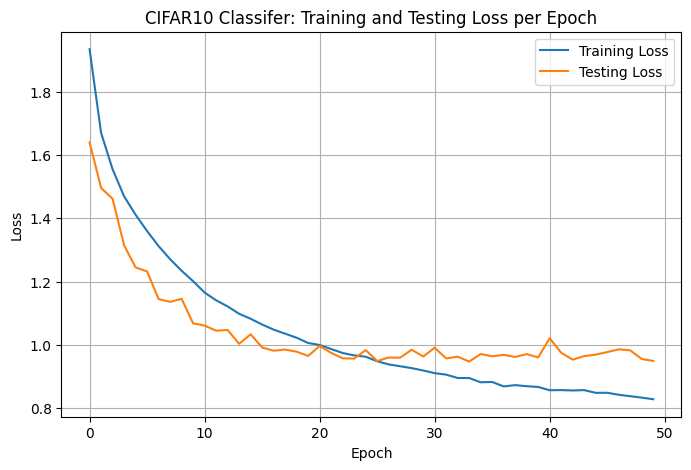

In [18]:
model.eval()

correct = total = 0

with torch.no_grad():
    for xb, yb in testset_loader_CIFAR10:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        pred = logits.argmax(1)
        correct += (pred == yb).sum().item()
        total += yb.numel()

final_accuracy = float(correct / total)

print(f"Final Accuracy: {final_accuracy}")

epochs = [d["epoch"] for d in epoch_over_training_loss_CIFAR10]
train_loss = [d["training_loss"] for d in epoch_over_training_loss_CIFAR10]
test_loss = [d["testing_loss"] for d in epoch_over_testing_loss_CIFAR10]

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, test_loss, label="Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CIFAR10 Classifer: Training and Testing Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

RESULTS.....


#### Model Architecture 1

In the beginning, I decided that I wanted to have two convolutional layers, one that extracted a lot of features from the image data and one that found more advanced features. Since the first layer would find as many initial features to start, I decided to make the out channel 128 and kernel size 5x5. Then, the second layer would condense those features, so I chose an out channel size of 64 and kernel size of 3x3. Additionally, I stacked 4 decreasing, funneling, fully-connected layers, 1000 -> 1000 -> 500 -> 100, that finally connected to the output layer. My reasoning was that doing this would allow me to find complex features that would become more and more concentrated and meaningful. Finally, I added a max pooling layer after the convolutional layers to help reduce dimensionality of the data and dropout layers after every layer to prevent overfitting. 

#### Optimizer
I went with Adam since I wanted to experiment with using different options. Furthermore, I wanted my loss to be as low as possible, so I wanted to use weight decay. As such, the final optimizer I used was AdamW since it handles weight decay better.

#### Initial training

I started with initial hyperparamters of batch_size = 64, learning_rate = 1e-3, decay_rate = 5e-4 (weight decay), c_dropout = 0.40 (the dropout probability for each convolutional layer), and f_dropout = 0.60 (the dropout probability for each fully-connected layer). After the first training, I noticed that my losses were not really good for this data set, training loss ~= 1.3 and testing loss ~= 1.25. Specially, they could never get past the 1.2 barrier and started to stagnate at the 14th epoch. Since I did not think overfitting was an issue yet, I decided to tweak the learning rate from 1e-3 to 5e-4.

In the second trial, I noticed that the issue of the model not being able to learn was still present, losses similar to the first trial, so I thought the maybe my dropout p's were a bit too high. This caused me to set both of them to 0.4.

In my next training attempt, I saw I was able to break past the 1.2 loss barrier by the 10th epoch which solidified my reasoning that my p's were too high, but I was unable to get a testing loss lower than ~1.10 after the 15th epoch. However, I did notice that model was still learning well, it was able to get training loss lower than 1.10, so I decided that I should try changing the weight decay to 4e-4 to see if it would help. I did not increase the weight decay since I thought that would cause my losses to be greater since I was already using a good amount of dropout.

For the fourth trial, I saw that I got similar testing loss, ~1.08, so I decided to try changing the other hyperparameters. Yet, no matter which ones I tried to change, I was unable to break the testing loss = 1.00 barrier, even though the model was learning well beyond that point. This led me to think that my architecture was a bit too complex, so I decided to rethink of what I was doing and change my model.

#### Model Architecture 2

For this iteration of the model, I decided to change the number of channels in my convolutional layers from 128 -> 64 to 30 -> 64. This happened because I decided to look at the image size which is 32x32 and realized that I might be trying to find too many features in the beginning but then sampling them down too much in the second layer. Instead, it would probably be better to find fewer initial features and then find complex relationships between them in the second convolutional layer. The second major change I made was making the fully-connected layers continously decreasing from 1000 -> 1000 -> 500 -> 100 to 1000 -> 500 -> 250 -> 100 since I wanted to downscale the model.

#### Training for Second Model

I decided to keep the hyperparameters that I obtained from the initial model since I thought they might work well with this new model, batch_size = 64, learning_rate = 5e-4, and decay_rate = 4e-4. However, I chose to decrease the dropouts both to 0.25 since I wanted to start at a new, lower point and tweak the dropout as I trained this new model.

For the first training attempt, my model performed way better than the first model both in terms of speed and accuracy since it was able to get training loss ~= 0.9 and testing loss ~= 0.89 at the 5th epoch. Beyond that point though, the model started overfitting severally and could not get past the testing loss being ~0.89. Instead of trying

#### Model Architecture 3


In [9]:
class CIFAR10_Transformed_Classifier(CIFAR10_Classifier):
    def __init__(self, C_dropout, F_dropout):
        super().__init__(C_dropout, F_dropout)
        
        self.output_layer = nn.Linear(in_features=self.output_nodes, out_features=2)


    def forward(self, x):
        x = self.partial_forward(x)
        logits = self.output_layer(x)

        return logits


In [11]:
epoch_over_training_loss_CIFAR10_R = []
epoch_over_testing_loss_CIFAR10_R = []

In [ ]:
# Hyperparameter setup
epochs = 30
batch_size = 64
learning_rate = 1e-4
decay_rate = 1e-4

c_dropout = 0.40
f_dropout = 0.50


print('######## Begining training for CIFAR10 classifier on rotated images ##########')

# Setup data loaders
trainset_loader_CIFAR10_R = data.DataLoader(trainset_full_CIFAR10,
                                   batch_size=batch_size,
                                   shuffle=True,
                                   # num_workers=5,
                                   pin_memory=True)

testset_loader_CIFAR10_R = data.DataLoader(testset_full_CIFAR10,
                                   batch_size=batch_size,
                                   # num_workers=5,
                                   shuffle=False,
                                   pin_memory=True)

model = CIFAR10_Transformed_Classifier(c_dropout, f_dropout)
model.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), 
                       lr=learning_rate, 
                       weight_decay=decay_rate
                       )

# Have references to variables outside of the epoch loop
avg_training_loss = 0
avg_testing_loss = 0

# Epoch Loop
for epoch in range(epochs):
    print(f'----- Epoch: {epoch + 1}/{epochs} -----')
    
    avg_training_loss = 0
    avg_testing_loss = 0

    model.train()

    for x, _ in tqdm(trainset_loader_CIFAR10_R, desc='Training', unit=' batch'):

        labels_upright = torch.zeros(x.size(0), dtype=torch.long)

        images_rotated = torch.rot90(x, 1, [2, 3])
        labels_rotated = torch.ones(x.size(0), dtype=torch.long)

        all_images = torch.cat([x, images_rotated])
        all_labels = torch.cat([labels_upright, labels_rotated])
        
        
        # Transfer images to GPU
        all_images = all_images.to(device)
        all_labels = all_labels.to(device)

        # Zero out gradients
        optimizer.zero_grad()

        # Send images to model
        x_pred = model(all_images)

        # Calc loss
        loss = loss_function(x_pred, all_labels)

        # Calc gradient and update weights
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            avg_training_loss += loss

    # Switch to eval mode
    model.eval()

    with torch.no_grad():
        for x, _ in tqdm(testset_loader_CIFAR10_R, desc='Testing', unit=' batches'):
            
            labels_upright = torch.zeros(x.size(0), dtype=torch.long)

            images_rotated = torch.rot90(x, 1, [2, 3])
            labels_rotated = torch.ones(x.size(0), dtype=torch.long)

            all_images = torch.cat([x, images_rotated])
            all_labels = torch.cat([labels_upright, labels_rotated])
            
            # Transfer images to GPU
            all_images = all_images.to(device)
            all_labels = all_labels.to(device)
            
            # Move the images to the GPU
            all_images = all_images.to(device)
            all_labels = all_labels.to(device)

            # Get logits and sum up total loss
            x_pred = model(all_images)
            avg_testing_loss += loss_function(x_pred, all_labels).item()

    # Get training loss
    avg_training_loss /= len(trainset_loader_CIFAR10)

     # Get testing loss
    avg_testing_loss /= len(testset_loader_CIFAR10)

    # Switch model back to training mode
    model.train()

    epoch_over_training_loss_CIFAR10_R.append({
        "epoch": epoch,
        "training_loss": avg_training_loss
        })
    
    epoch_over_testing_loss_CIFAR10_R.append({
        "epoch": epoch,
        "testing_loss": avg_testing_loss
        })
    

    print("")

    print(f'   -> Training Loss: {avg_training_loss: .4f}\n')
    print(f'   -> Testing Loss: {avg_testing_loss: .4f}\n')


In [ ]:
# Save the model weights from problem 5
torch.save(model.state_dict(), 'Q4_model_weights.pth')

In [ ]:
model.eval()
correct = total = 0
with torch.no_grad():
    for x, _ in testset_loader_CIFAR10_R:
        
        labels_upright = torch.zeros(x.size(0), dtype=torch.long)

        images_rotated = torch.rot90(x, 1, [2, 3])
        labels_rotated = torch.ones(x.size(0), dtype=torch.long)

        all_images = torch.cat([x, images_rotated])
        all_labels = torch.cat([labels_upright, labels_rotated])
        
        # Transfer images to GPU
        all_images = all_images.to(device)
        all_labels = all_labels.to(device)
        
        # Move the images to the GPU
        all_images = all_images.to(device)
        all_labels = all_labels.to(device)

        # Get logits and sum up total loss
        logits = model(all_images)
        
        pred = logits.argmax(1)
        
        correct += (pred == all_labels).sum().item()
        total += all_labels.numel()

final_accuracy = float(correct / total)

print(f"Final Accuracy: {final_accuracy}")


epochs = [d["epoch"] for d in epoch_over_training_loss_CIFAR10_R]
train_loss = [d["training_loss"] for d in epoch_over_training_loss_CIFAR10_R]
test_loss = [d["testing_loss"] for d in epoch_over_testing_loss_CIFAR10_R]

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, test_loss, label="Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CIFAR10 Rotation Classifer: Training and Testing Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

Results

---

Training Loss = 

Testing Loss = 

Final Testing Loss = 


epochs = 15

batch_size = 64

learning_rate = 1e-4

decay_rate = 5e-4


c_dropout = 0.40

f_dropout = 0.50

---

Initially, I decided to start with the same hyperparameters as the final model in Question 3 just to see what the current losses were looking like. As a result, I was able to get a training and testing loss around 0.38. Though in this run, I decided to end the training early since I noticed that the model was overtraining starting from the 14th epoch and beyond.

Noticing the issue of overtraining, I decided to switch to the AdamW optimizer since it handles weight decay better. However, I still got similar results at the 14th epoch. Instead of focusining on changing the optimizer, I decided to try and change the dropout percentages. 

In the third trial, I changed the dropout rates from 0.3, convolutional dropout, to 0.4 which allowed me to achieve a better training loss around 0.33 and testing loss around 0.31. During this run, I noticed that the model began to learn slower by the 10th epoch and then began overtraining by the 14th epoch. 

For the forth attempt, I tried to increase the learning rate from 7.5e-5 to 1e-4 and sadly did not see any better results by the time the model started overtraining at the 14 epoch, however, I was able to achieve similar losses around 0.31.

On the fifth trial, I decided that the model learning rate was being affected by the dropout rate on the fully connected layer, so I decreased it to 0.50. This allowed me to get a training loss around 0.301 and testing loss around 0.297 at the 14th epoch. The decrease in loss was nice, but I still needed to deal with overtraining since the model could never get past this testing loss barrier at around 0.29.

On the sixth run, I wanted to experiment with a higher weight decay rate, increased from 5e-4 to 7.5e-4, but this resulted in my model starting to overtrain at the 15th epoch with a min testing loss of 0.3032. Though, I still wanted to see if it would be wise to tinker with the decay rate, so I instead decreased it to 2.5e-4 on the 7th run which gave me the same issue of overtraining past the 15th epoch and a final testing loss of around 0.29.

At this point, I believed that I have found the most optimal hyperparameters for my model based on the current architecture, so I did one final training.


In [12]:
def transfer_weights(model_final, model_src, k, is_frozen):
    
    for i in range(len(model_final.forward_funnel_1)):

        if k == 0: return

        src_layer = model_src.forward_funnel_1[i]
        final_layer = model_final.forward_funnel_1[i]

        if (hasattr(src_layer, 'weight') and hasattr(final_layer, 'weight')):
            final_layer.weight.data = src_layer.weight.data.clone()
            if is_frozen:
                final_layer.weight.requires_grad = False
            
            # This will always run if we get here. I do not intend on making layers with biases
            if (hasattr(src_layer, 'bias') and hasattr(final_layer, 'bias')):
                final_layer.bias.data = src_layer.bias.data.clone()
                if is_frozen:
                    final_layer.bias.requires_grad = False

                k -= 1

    
    for i in range(len(model_final.classifer)):
        
        if k == 0: return

        src_layer = model_src.classifer[i]
        final_layer = model_final.classifer[i]

        if (hasattr(src_layer, 'weight') and hasattr(final_layer, 'weight')):
            final_layer.weight.data = src_layer.weight.data.clone()
            if is_frozen:
                final_layer.weight.requires_grad = False
            
            # This will always run if we get here. I do not intend on making layers with biases
            if (hasattr(src_layer, 'bias') and hasattr(final_layer, 'bias')):
                final_layer.bias.data = src_layer.bias.data.clone()
                if is_frozen:
                    final_layer.bias.requires_grad = False

                k -= 1

In [13]:
epoch_over_training_loss_CIFAR10_per_k = []
epoch_over_testing_loss_CIFAR10_per_k = []

'''
For of the data for this list is...

data = {
    k: int
    epoch: int
    training/testing loss: floats
    frozen: True or False
}

'''

'\nFor of the data for this list is...\n\ndata = {\n    k: int\n    epoch: int\n    training/testing loss: floats\n    frozen: True or False\n}\n\n'

In [ ]:
# Hyperparameter setup
epochs = 30
batch_size = 64
learning_rate = 1e-4
decay_rate = 1e-4

c_dropout = 0.40
f_dropout = 0.50

k = 5 # Max number of layers for the current model ~~ Excluding the output layer

# Initialize model for the sake of weight transfer
src_model = CIFAR10_Transformed_Classifier(c_dropout, f_dropout)
src_model.load_state_dict(torch.load('Q4_model_weights.pth'))


print('######## Begining training for CIFAR10 classifier + transfer learning ##########')

for i in range(2):
    
    is_frozen = False if i == 0 else True
    
    for current_k in range(1, k, 1):
        # Setup data loaders
        trainset_loader_CIFAR10 = data.DataLoader(trainset_full_CIFAR10,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        # num_workers=5,
                                        pin_memory=True)

        testset_loader_CIFAR10 = data.DataLoader(testset_full_CIFAR10,
                                        batch_size=batch_size,
                                        # num_workers=5,
                                        shuffle=False,
                                        pin_memory=True)

        model_final = CIFAR10_Classifier(c_dropout, f_dropout)

        transfer_weights(model_final, src_model, k, is_frozen)

        model_final.to(device)

        loss_function = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model_final.parameters(), 
                            lr=learning_rate, 
                            weight_decay=decay_rate
                            )

        # Have references to variables outside of the epoch loop
        avg_training_loss = 0
        avg_testing_loss = 0

        # Epoch Loop
        for epoch in range(epochs):
            print(f'----- Epoch: {epoch + 1}/{epochs} -----')
            
            avg_training_loss = 0
            avg_testing_loss = 0

            model_final.train()

            for x, _ in tqdm(trainset_loader_CIFAR10, desc='Training', unit=' batch'):

                labels_upright = torch.zeros(x.size(0), dtype=torch.long)

                images_rotated = torch.rot90(x, 1, [2, 3])
                labels_rotated = torch.ones(x.size(0), dtype=torch.long)

                all_images = torch.cat([x, images_rotated])
                all_labels = torch.cat([labels_upright, labels_rotated])
                
                
                # Transfer images to GPU
                all_images = all_images.to(device)
                all_labels = all_labels.to(device)

                # Zero out gradients
                optimizer.zero_grad()

                # Send images to model
                x_pred = model_final(all_images)

                # Calc loss
                loss = loss_function(x_pred, all_labels)

                # Calc gradient and update weights
                loss.backward()
                optimizer.step()

                with torch.no_grad():
                    avg_training_loss += loss

            # Switch to eval mode
            model_final.eval()

            with torch.no_grad():
                for x, _ in tqdm(testset_loader_CIFAR10, desc='Testing', unit=' batches'):
                    
                    labels_upright = torch.zeros(x.size(0), dtype=torch.long)

                    images_rotated = torch.rot90(x, 1, [2, 3])
                    labels_rotated = torch.ones(x.size(0), dtype=torch.long)

                    all_images = torch.cat([x, images_rotated])
                    all_labels = torch.cat([labels_upright, labels_rotated])
                    
                    # Transfer images to GPU
                    all_images = all_images.to(device)
                    all_labels = all_labels.to(device)
                    
                    # Move the images to the GPU
                    all_images = all_images.to(device)
                    all_labels = all_labels.to(device)

                    # Get logits and sum up total loss
                    x_pred = model_final(all_images)
                    avg_testing_loss += loss_function(x_pred, all_labels).item()

            # Get training loss
            avg_training_loss /= len(trainset_loader_CIFAR10)

            # Get testing loss
            avg_testing_loss /= len(testset_loader_CIFAR10)

            # Switch model back to training mode
            model_final.train()

            epoch_over_training_loss_CIFAR10_per_k.append({
                "k": current_k,
                "epoch": epoch,
                "training_loss": avg_training_loss
                })
            
            epoch_over_testing_loss_CIFAR10_per_k.append({
                "k": current_k,
                "epoch": epoch,
                "training_loss": avg_training_loss
                })
            

            print("")

            print(f'   -> Training Loss: {avg_training_loss: .4f}\n')
            print(f'   -> Testing Loss: {avg_testing_loss: .4f}\n')

    


FileNotFoundError: [Errno 2] No such file or directory: 'Q4_model_weights.pth'

In [ ]:
# Separate frozen and unfrozen runs
for frozen_status, title in zip([True, False], ["Frozen Transfer Learning", "Unfrozen Transfer Learning"]):
    plt.figure(figsize=(10, 6))
    ks = sorted(set(d["k"] for d in epoch_over_training_loss if d["frozen"] == frozen_status))
    for k in ks:
        epochs = [d["epoch"] for d in epoch_over_training_loss if d["k"] == k and d["frozen"] == frozen_status]
        train_loss = [d["training_loss"] for d in epoch_over_training_loss if d["k"] == k and d["frozen"] == frozen_status]
        test_loss = [d["training_loss"] for d in epoch_over_testing_loss if d["k"] == k and d["frozen"] == frozen_status]
        plt.plot(epochs, train_loss, label=f"Train k={k}")
        plt.plot(epochs, test_loss, '--', label=f"Test k={k}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title + ": Epoch vs. Loss (per k)")
    plt.legend()
    plt.grid(True)
    plt.show()

In [23]:
class CIFAR10_Encoder(CIFAR10_Classifier):
    def __init__(self, C_dropout, F_dropout, embedding_size=2):
        super().__init__(C_dropout, F_dropout)

        self.output_layer = nn.Linear(in_features=self.output_nodes, out_features=embedding_size)

    def forward(self, x):

        x = self.partial_forward(x)
        logits = self.output_layer(x)

        return logits

In [15]:
class ContrastiveCIFAR10(data.Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
        self.labels = np.array(self.base_dataset.targets)

        # Pre-compute a dictionary mapping each class to a list of its indices
        self.labels_to_indices = {label: np.where(self.labels == label)[0]
                                  for label in set(self.labels)}

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, index):
        # Get the anchor image and its label
        img1, label1 = self.base_dataset[index]

        # Decide whether to sample a positive or negative pair (50% chance)
        is_similar = random.random() > 0.5

        if is_similar:
            # Positive pair: sample another image from the same class
            positive_indices = self.labels_to_indices[label1]
            # Make sure we don't pick the same image
            positive_index = index
            while positive_index == index:
                positive_index = np.random.choice(positive_indices)
            img2, _ = self.base_dataset[positive_index]
            similarity = 1.0 # Similarity label is 1 for positive pairs
        else:
            # Negative pair: sample an image from a different class
            negative_label = np.random.choice(list(set(self.labels) - {label1}))
            negative_indices = self.labels_to_indices[negative_label]
            negative_index = np.random.choice(negative_indices)
            img2, _ = self.base_dataset[negative_index]
            similarity = 0.0 # Similarity label is 0 for negative pairs

        return img1, img2, torch.tensor(similarity, dtype=torch.float32)

In [16]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, embedding1, embedding2, similarity_label):
        # Calculate the euclidean distance squared between the embeddings
        euclidean_distance = F.pairwise_distance(embedding1, embedding2, keepdim=True)
        dist_sq = torch.pow(euclidean_distance, 2)

        # Loss for similar pairs (S=1): we want their distance to be small
        loss_similar = similarity_label * dist_sq

        # Loss for dissimilar pairs (S=0): we want their distance to be large, at least > margin
        # The loss is max(0, margin - distance)^2
        loss_dissimilar = (1 - similarity_label) * torch.pow(
            torch.clamp(self.margin - euclidean_distance, min=0.0), 2
        )

        # Combine the losses and average over the batch
        total_loss = torch.mean(loss_similar + loss_dissimilar)
        return total_loss

In [17]:
def get_all_embeddings(model, loader):
    model.eval()
    embeddings = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            embs = model(images).cpu().numpy()
            embeddings.append(embs)
            all_labels.append(labels.numpy())
    return np.concatenate(embeddings), np.concatenate(all_labels)

In [18]:
def plot_embeddings(embeddings, labels, title=""):
    plt.figure(figsize=(10, 8))
    class_names = trainset_full_CIFAR10.classes
    for i in range(len(class_names)):
        # Select embeddings that correspond to the current class
        inds = np.where(labels == i)[0]
        plt.scatter(embeddings[inds, 0], embeddings[inds, 1], alpha=0.5, label=class_names[i])
    plt.title(title)
    plt.legend()
    plt.show()

In [ ]:
# Hyperparameter setup
epochs = 30
batch_size = 64
learning_rate = 7.5e-5
decay_rate = 5e-4

c_dropout = 0.30
f_dropout = 0.62

embedding_model = CIFAR10_Encoder(c_dropout, f_dropout).to(device)
contrastive_loss_fn = ContrastiveLoss(margin=1.0)
optimizer = optim.Adam(embedding_model.parameters(), lr=learning_rate, weight_decay=decay_rate)

contrastive_train_ds = ContrastiveCIFAR10(trainset_full_CIFAR10)
contrastive_train_loader = data.DataLoader(contrastive_train_ds, 
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           pin_memory=True)

print(f'######## Starting training of CIFAR10 embedding model ##########')

embedding_model.train()

for epoch in range(epochs):
    print(f'----- Epoch: {epoch + 1}/{epochs} -----')

    running_loss = 0.0
    for img1, img2, sim in tqdm(contrastive_train_loader, desc='Training', unit=' batchs'):
        img1, img2, sim = img1.to(device), img2.to(device), sim.to(device)

        optimizer.zero_grad()
        emb1, emb2 = embedding_model(img1), embedding_model(img2)
        loss = contrastive_loss_fn(emb1, emb2, sim)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"  -> [Contrastive] Epoch {epoch+1}/3 | Loss={running_loss/len(contrastive_train_loader):.4f}")

######## Starting training of CIFAR10 embedding model ##########
----- Epoch: 1/30 -----


Training:   0%|          | 0/782 [00:00<?, ? batchs/s]

In [ ]:
test_loader_vis = data.DataLoader(testset_full_CIFAR10, batch_size=256, shuffle=False)

final_embeddings, final_labels = get_all_embeddings(embedding_model, test_loader_vis)
plot_embeddings(final_embeddings, final_labels, "Embeddings After Training")